# Exploratory Data Analysis

## Section 1: Loading the data

### Import the relevant libraries and load the dataset

In [35]:
# Import the required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the dataset
data_path = 'ai4i2020.csv'
df = pd.read_csv(data_path)

# Display the first few rows of the dataset to understand its structure
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

### Preliminary data quality checks

In [36]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Basic descriptive statistics to identify potential outliers
print("\nDescriptive statistics:")
print(df.describe())

Missing values per column:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

Number of duplicate rows: 0

Descriptive statistics:
               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000      

## Section 2: Begin basic data analysis

### Visualise the pairwise relationships between each factor

C:\Users\wongd\anaconda3\envs\NTU\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



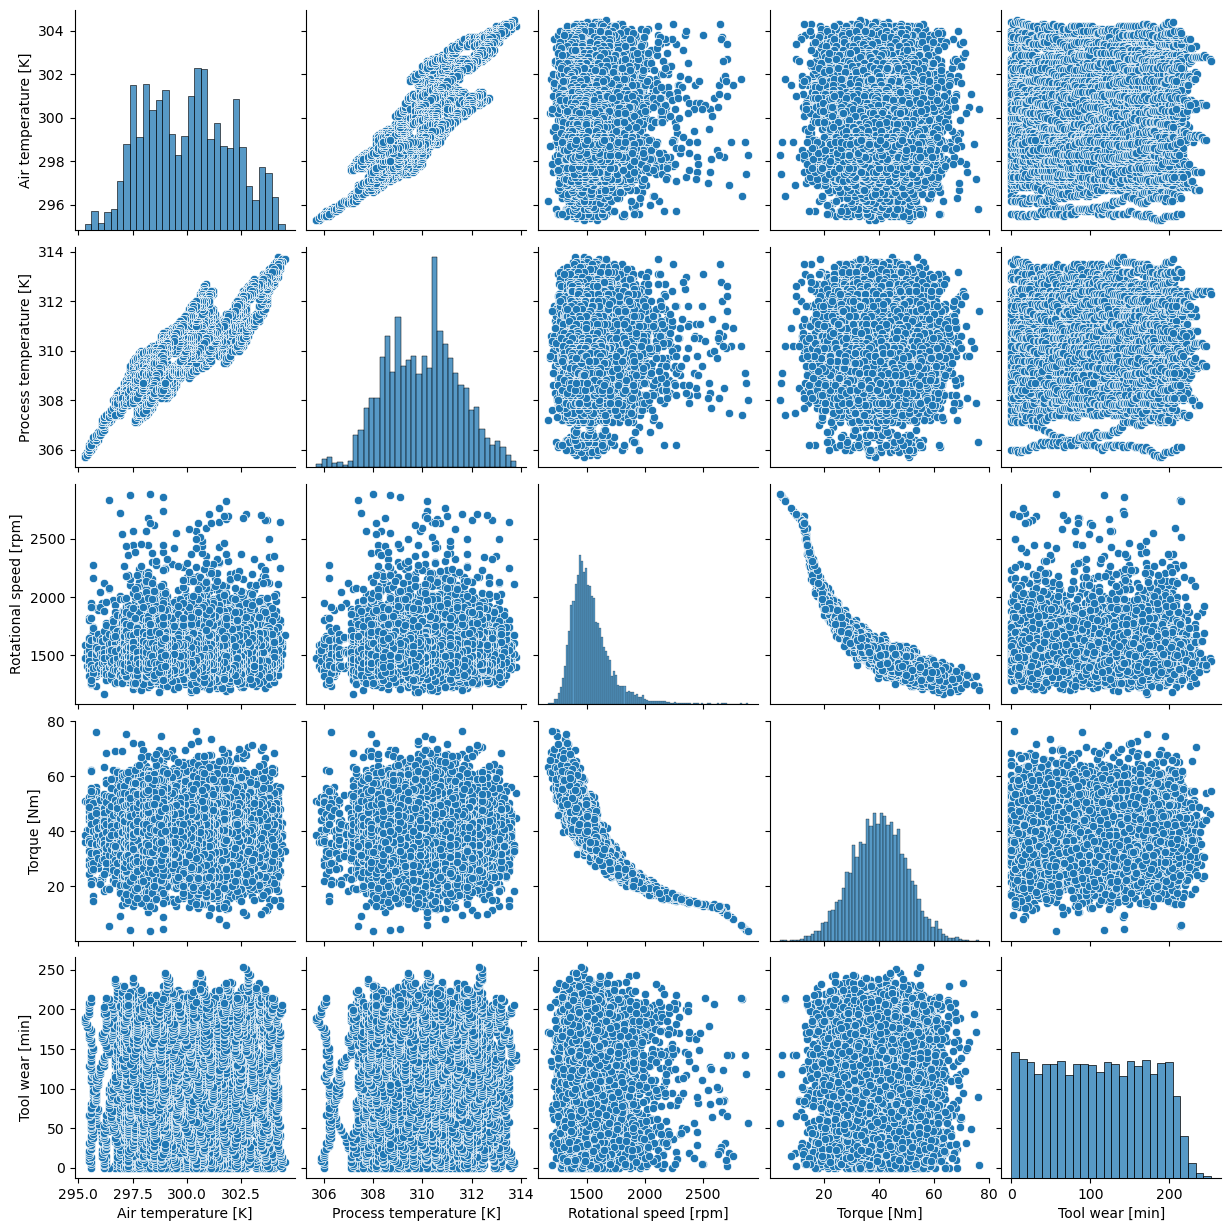

In [38]:
# Select a subset of columns if the dataset is very large
columns_to_plot = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
sns.pairplot(df[columns_to_plot])
plt.show()

### Begin analysis for the different failures

In [39]:
# Summarizing the total number of instances for each failure mode and non-failures
failure_modes_summary = df[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum().reset_index()
failure_modes_summary.columns = ['Type', 'Count']

# Display the summary
failure_modes_summary

Type  Count
0  Machine failure    339
1              TWF     46
2              HDF    115
3              PWF     95
4              OSF     98
5              RNF     19

### Visualise the factors in histograms to understand the spread

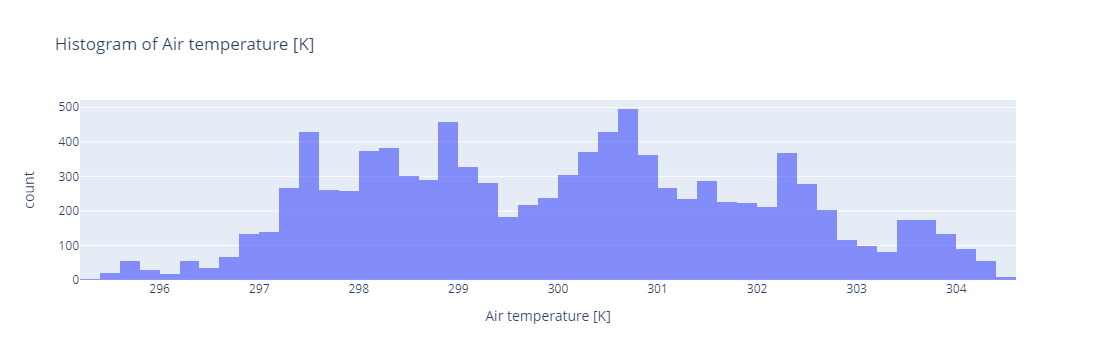

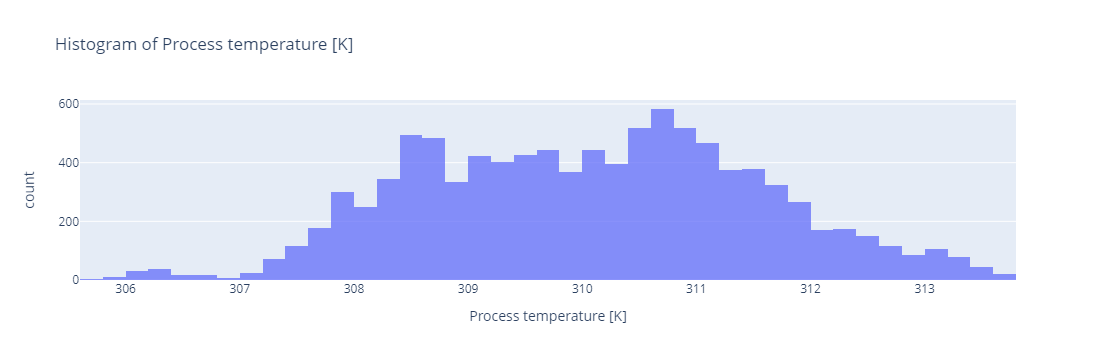

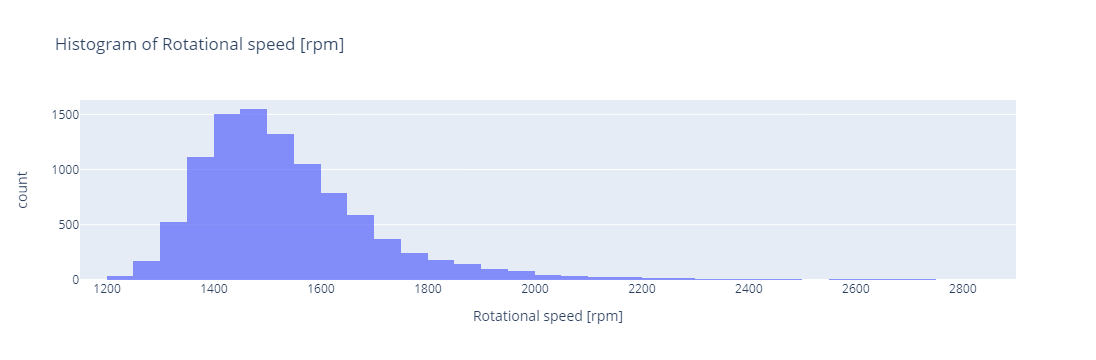

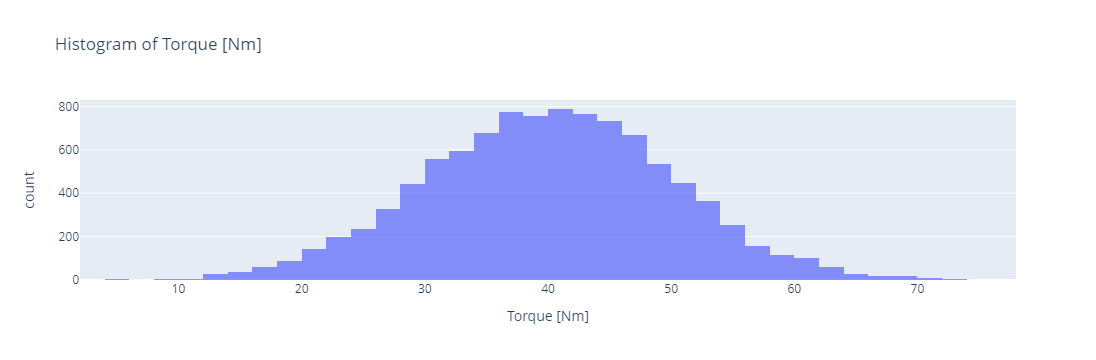

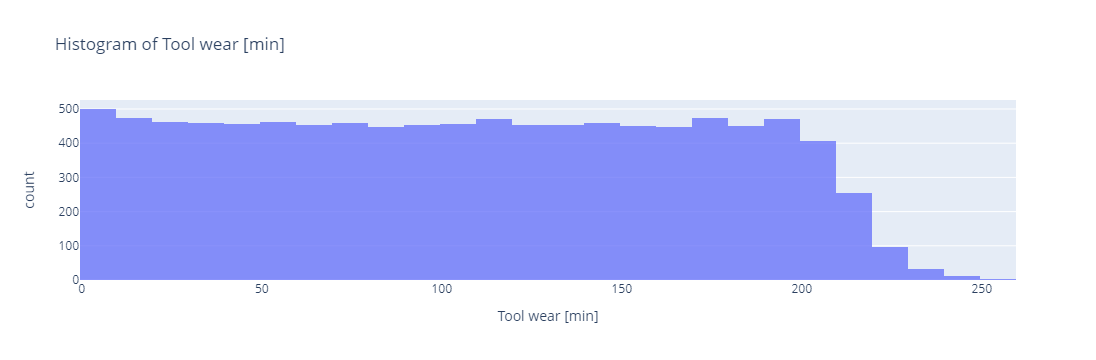

In [40]:
# List of factors you're interested in visualizing
factors = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Creating histograms for each factor
for factor in factors:
    fig = px.histogram(df, x=factor,
                       title=f"Histogram of {factor}",
                       nbins=50, # Adjust the number of bins for better visualization
                       opacity=0.75) # Adjust opacity to see the distribution clearly
    fig.show()

### Visualise the % of failure of each mode, however, keeping in mind that some machine failures constitute mulitple modes of failures

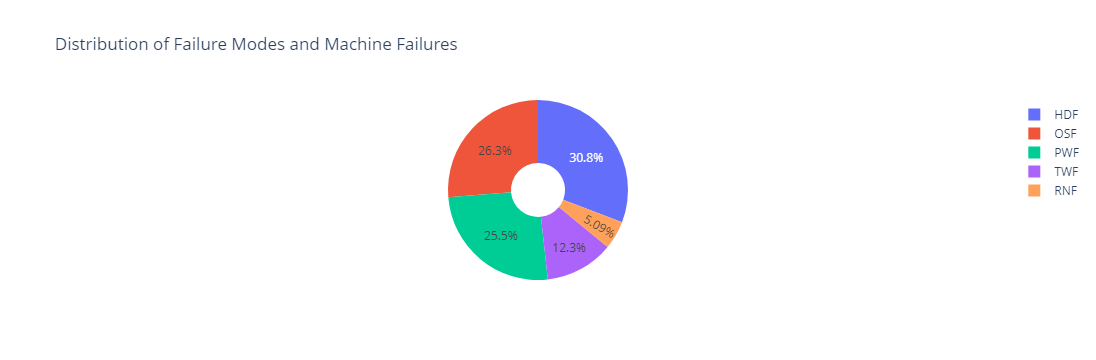

In [43]:
# Prepare data for the pie chart
failure_modes = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum().reset_index()
failure_modes.columns = ['Type', 'Count']
labels = failure_modes['Type']
values = failure_modes['Count']

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="Distribution of Failure Modes and Machine Failures")

# Show the figure
fig.show()

### Plot some barplots

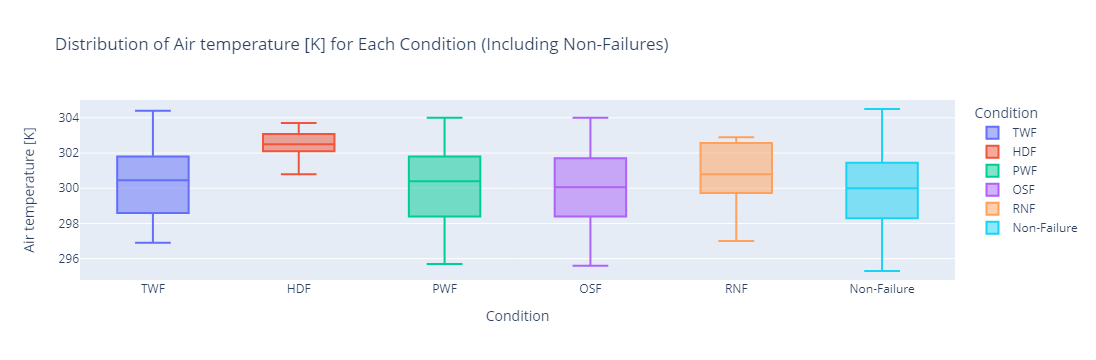

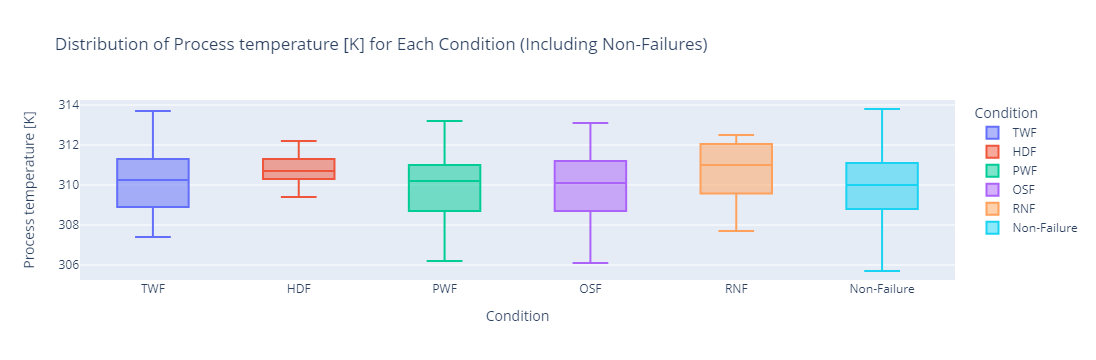

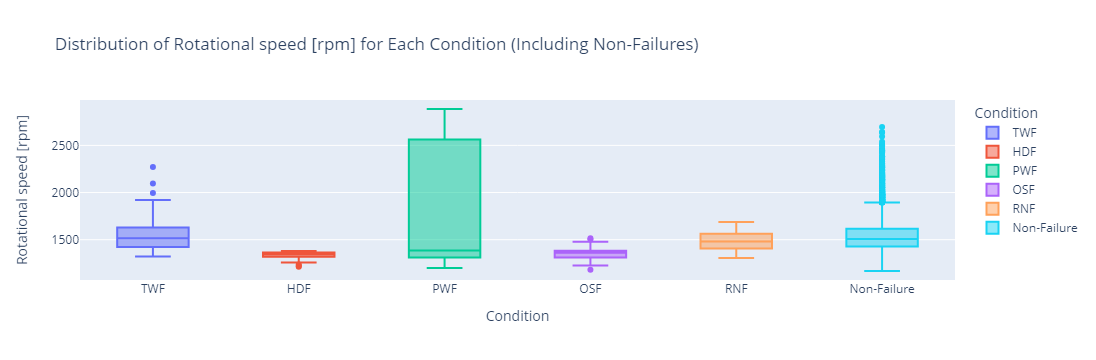

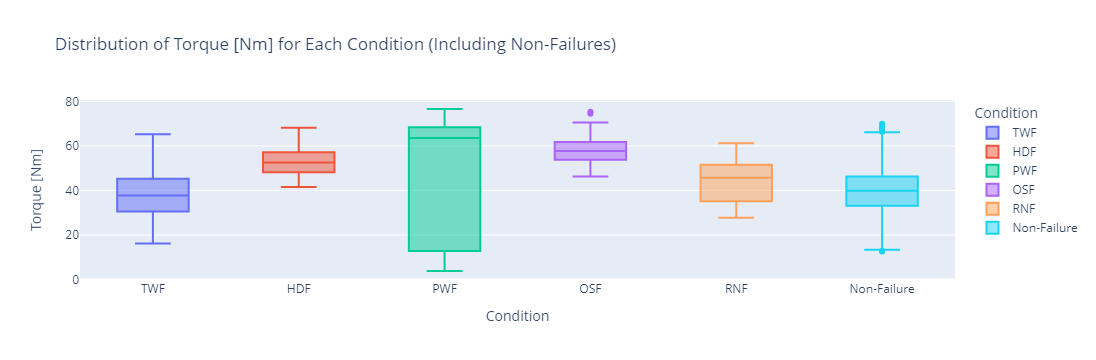

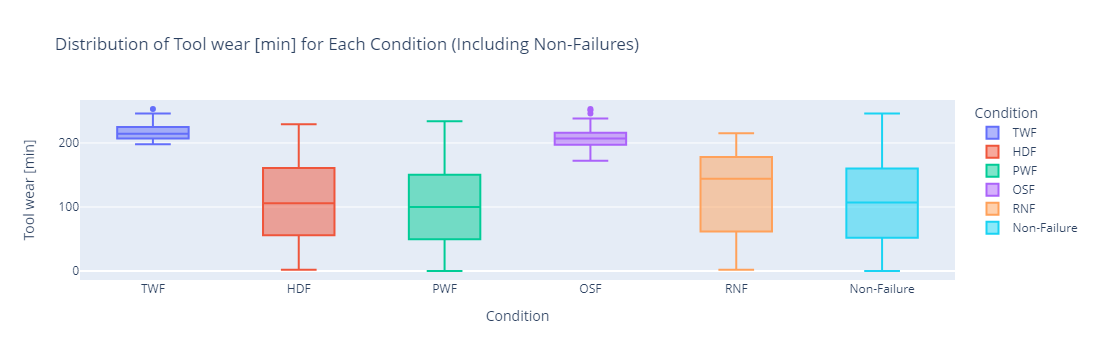

In [44]:
# Filter the data for instances where any specific type of failure occurred
failure_data = df[df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].any(axis=1)]

# Melt the dataframe to have a long format suitable for plotting with Plotly Express
melted_failure_data = failure_data.melt(id_vars=['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                                                 'Torque [Nm]', 'Tool wear [min]'], 
                                        value_vars=['TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
                                        var_name='Failure Type', value_name='Failure Occurred')

# Filter out the rows where failure did not occur
melted_failure_data = melted_failure_data[melted_failure_data['Failure Occurred'] == 1]
no_failure_data = melted_failure_data[melted_failure_data['Failure Occurred'] == 0]


# Add a 'Non-Failure' column to represent non-failure instances
df['Non-Failure'] = (df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1) == 0).astype(int)

# Melt the dataframe to include both failure and non-failure instances
melted_data_all = df.melt(id_vars=['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                                   'Torque [Nm]', 'Tool wear [min]'], 
                          value_vars=['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Non-Failure'],
                          var_name='Condition', value_name='Occurred').query('Occurred == 1')

# Create box plots for each factor, comparing across different conditions (including non-failures)
for factor in ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']:
    fig = px.box(melted_data_all, x='Condition', y=factor, 
                 title=f'Distribution of {factor} for Each Condition (Including Non-Failures)',
                 color='Condition')
    fig.show()


### Visualise where the failures often occur with respect to the histograms

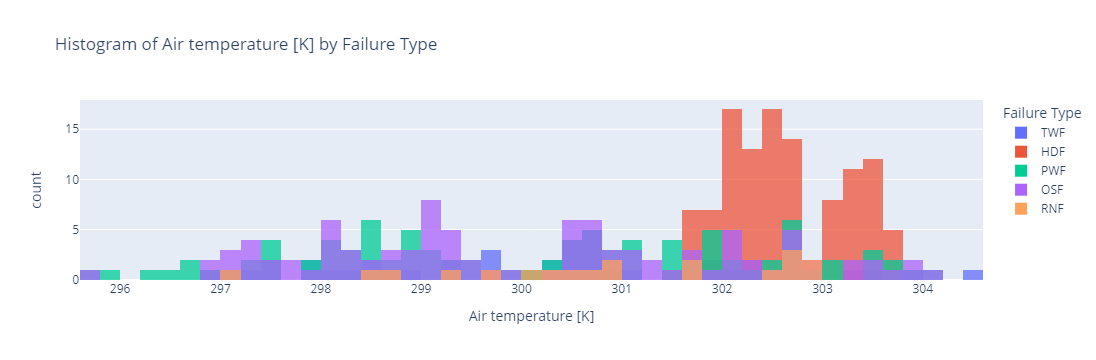

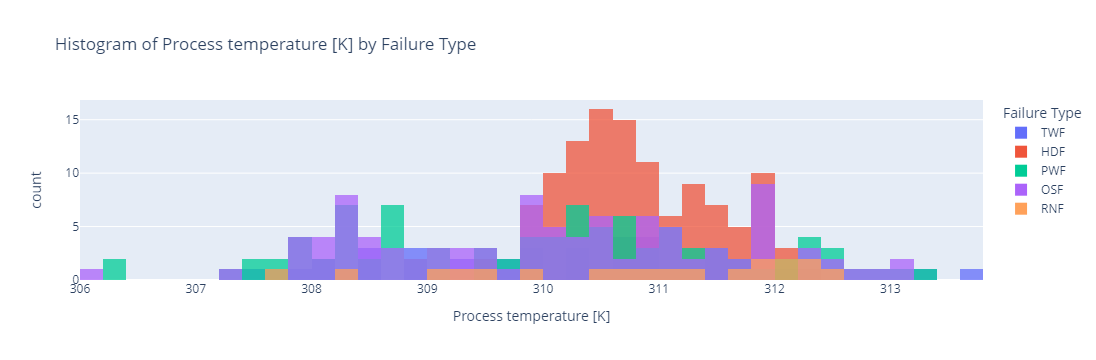

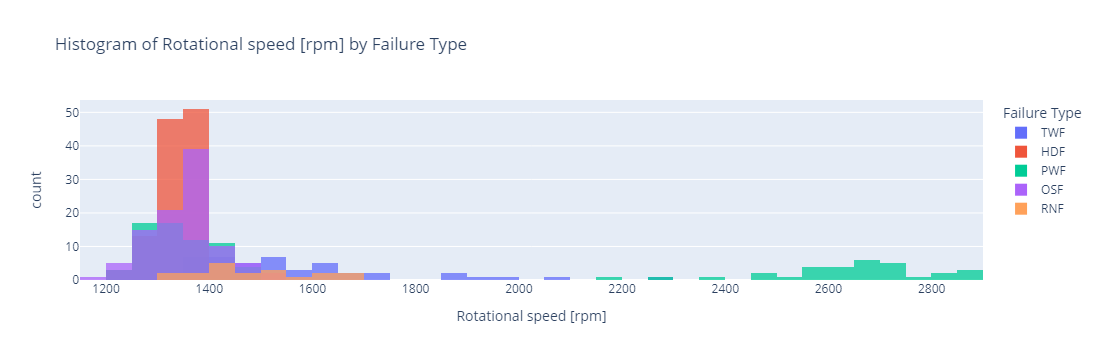

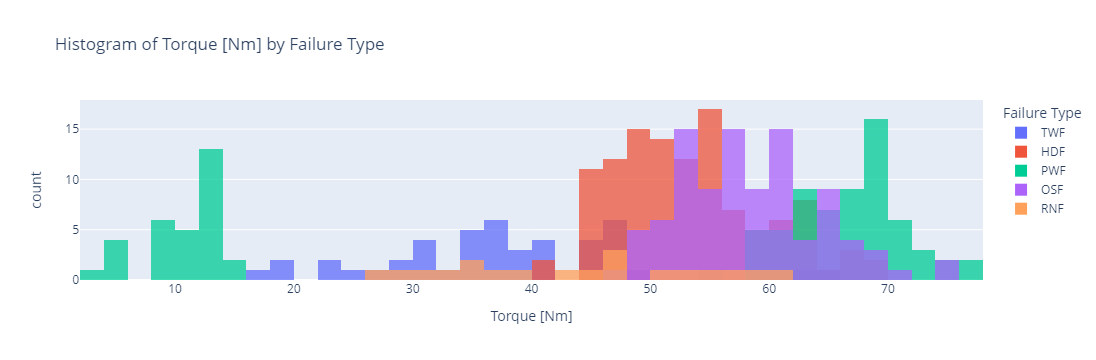

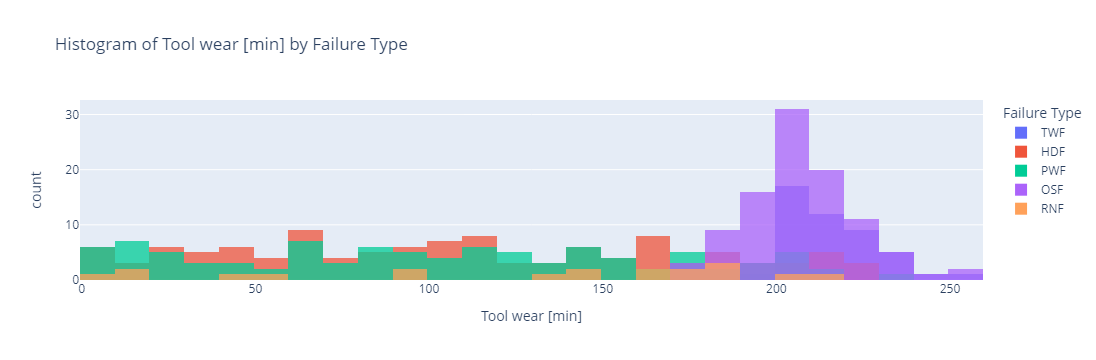

In [45]:
factors = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Creating histograms for each factor, broken down by failure type
for factor in factors:
    fig = px.histogram(melted_failure_data, x=factor, color="Failure Type",
                       title=f"Histogram of {factor} by Failure Type",
                       labels={"Failure Type": "Failure Type"},
                       barmode="overlay", # Overlay the histograms for comparison
                       nbins=50, # Adjust the number of bins for better visualization
                       opacity=0.75) # Adjust opacity to see overlapping bars
    fig.show()

### Plot a correlation matrix to visualise the relationship between each factor

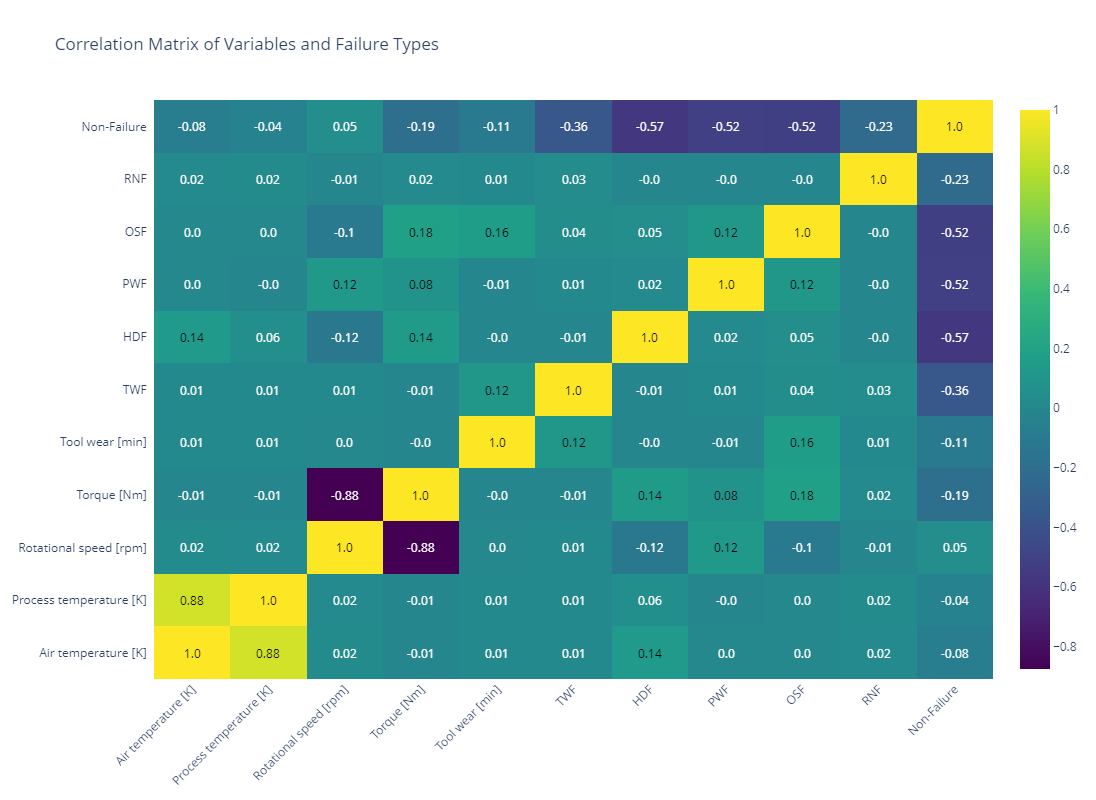

In [46]:
cleaned_df = df.drop(columns =['UDI','Product ID', 'Type', 'Machine failure'])

# Calculating the correlation matrix
correlation_matrix = cleaned_df.corr()

# Visualizing the correlation matrix using Plotly
fig = ff.create_annotated_heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns.tolist(),
    y=correlation_matrix.index.tolist(),
    colorscale='Viridis',
    annotation_text=correlation_matrix.round(2).values,
    showscale=True
)

fig.update_layout(title='Correlation Matrix of Variables and Failure Types',
                  xaxis=dict(tickangle=-45, side='bottom'),
                  yaxis=dict(tickmode='array', tickvals=list(range(len(correlation_matrix.index)))),
                  width=800, height=800)

fig.show()



### Perform PCA (for fun)

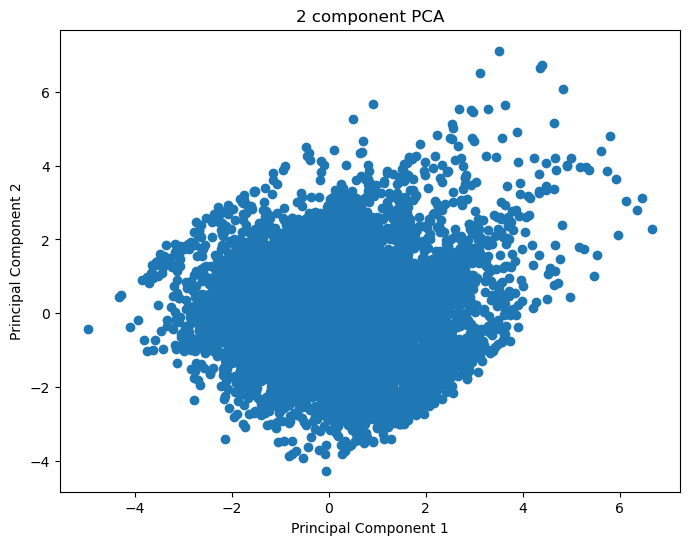

Explained variance ratio: [0.3821481  0.36817048]


In [48]:
# Selecting numerical features for PCA
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
x = df.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# Performing PCA
pca = PCA(n_components=2)  # Reducing to 2 dimensions as an example
principalComponents = pca.fit_transform(x)

# Creating a DataFrame with principal component values
principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal Component 1', 'Principal Component 2'])

# Visualizing the PCA results
plt.figure(figsize=(8,6))
plt.scatter(principalDf['Principal Component 1'], principalDf['Principal Component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA')
plt.show()

# Explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)